# Computing Player PER

The **Player Efficiency Rating (PER)** is a metric first introduced by ESPN's John Hollinger. It is intended to capture a player's performance per minute that they play, as many of the traditional stats cannot be used to effectively compare players (Pts, Ast, Reb, Blk, Stl). 

However, this statistic is extremely tedious to compute. Just look at the formula here:

https://en.wikipedia.org/wiki/Player_efficiency_rating

Or here:

https://hackastat.eu/en/learn-a-stat-player-efficiency-rating-per/

The PER, according to Hollinger's original formulation, takes in *21 parameters*: 10 player statistics, 3 team statistics, and 8 league-wide statistics. This is monstrous! The exact computation of this for the whole league also requires some preprocessing to perform efficiently. The PER is meant to be a holistic metric of the player's contributions to their respective team's statistical production, however, from the practitioner's end, we would like the PER to be more accessible and more simple of a model of player performance.

Here, we will utilize machine learning to create a simple mathematical model that will model the PER.

## Load the Data

We wrote a whole scraping and preprocessing pipeline for this. We download the CSV that results from this process. For more info, check out the notebook *Scraping NBA Data + Analysis*.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Our data of all the necessary **player** parameters, along with their PER is here.

In [2]:
df = pd.read_csv('Player_PER.csv')

df

,PLAYER_NAME,TEAM_HIST,Season,MIN,PLAYER_FGM,PLAYER_FGA,PLAYER_FG3M,PLAYER_FTM,PLAYER_FTA,PLAYER_AST,...,TEAM_PTS,TEAM_OREB,TEAM_TOV,TEAM_PF,TEAM_DREB%,TEAM_PACE,PLAYER_RAW_PER,PLAYER_PACE_CORRECTED_PER,Min * cPER,PLAYER_PER
0,Aaron Gordon,2020-21 DEN,2020-21,1383.780000,231,499,59,97,149,161,...,8284,758,972.0,1374,0.751,99.3,0.318304,0.325100,449.866928,14.525479
1,Aaron Gordon,2021-22 DEN,2021-22,2375.418333,434,834,87,171,230,188,...,9243,752,1189.0,1639,0.752,99.9,0.336415,0.338694,804.539445,15.201557
2,Aaron Gordon,2019-20 ORL,2019-20,2017.143333,335,767,73,151,224,228,...,7831,751,937.0,1336,0.749,100.9,0.329583,0.335397,676.544103,15.232287
3,Aaron Henry,2021-22 PHI,2021-22,16.983333,1,5,0,0,0,0,...,9015,700,1027.0,1590,0.724,98.4,-0.146567,-0.149809,-2.544259,-6.723868
4,Aaron Holiday,2019-20 IND,2019-20,1617.331667,233,563,87,74,87,225,...,7989,636,967.0,1445,0.718,101.3,0.253952,0.257412,416.320241,11.690530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1669,Ziaire Williams,2021-22 MEM,2021-22,1346.466667,191,424,76,43,55,65,...,9480,1159,1082.0,1620,0.726,103.1,0.222252,0.216813,291.931368,9.731191
1670,Zion Williamson,2019-20 NOP,2019-20,668.141667,210,360,6,114,178,50,...,8341,797,1181.0,1524,0.729,106.3,0.538155,0.519828,347.318788,23.608341
1671,Zion Williamson,2020-21 NOP,2020-21,2025.890000,634,1037,10,369,529,226,...,8251,845,1052.0,1295,0.755,102.3,0.599331,0.594175,1203.733969,26.547773
1672,Zylan Cheatham,2019-20 NOP,2019-20,51.043333,6,9,0,0,0,3,...,8341,797,1181.0,1524,0.729,106.3,0.150970,0.145829,7.443590,6.622915


In [3]:
df.isnull().sum()

PLAYER_NAME                  0
TEAM_HIST                    0
Season                       0
MIN                          0
PLAYER_FGM                   0
PLAYER_FGA                   0
PLAYER_FG3M                  0
PLAYER_FTM                   0
PLAYER_FTA                   0
PLAYER_AST                   0
PLAYER_TOV                   0
PLAYER_OREB                  0
PLAYER_DREB                  0
PLAYER_STL                   0
PLAYER_BLK                   0
PLAYER_PF                    0
TEAM_FGM                     0
TEAM_AST                     0
TEAM_FGA                     0
TEAM_FTM                     0
TEAM_FTA                     0
TEAM_PTS                     0
TEAM_OREB                    0
TEAM_TOV                     0
TEAM_PF                      0
TEAM_DREB%                   0
TEAM_PACE                    0
PLAYER_RAW_PER               0
PLAYER_PACE_CORRECTED_PER    0
Min * cPER                   0
PLAYER_PER                   0
dtype: int64

## Preprocessing and Analysis

There is minimal preprocessing to be done here because the PER was computed according to a set formula. 

### Filter out Potential Outliers

One thing that we would do is to throw out the PER's of players who have little playtime/action. The player's PER's are usually EXTREMELY skewed in either direction. So we would like to filter out these entries.

In [4]:
# create a total rebounds category

df['PLAYER_TREB'] = df['PLAYER_DREB'] + df['PLAYER_OREB']

# create a total free throws missed category

df['PLAYER_FT_MISSED'] = df['PLAYER_FTA'] - df['PLAYER_FTM']

# create a total field goals missed category

df['PLAYER_FG_MISSED'] = df['PLAYER_FGA'] - df['PLAYER_FGM']


In [5]:
df[['MIN', 'PLAYER_FGA', 'PLAYER_FTA', 'PLAYER_AST', 'PLAYER_STL', 'PLAYER_BLK', 'PLAYER_TREB']].describe()

,MIN,PLAYER_FGA,PLAYER_FTA,PLAYER_AST,PLAYER_STL,PLAYER_BLK,PLAYER_TREB
count,1674.000000,1674.000000,1674.000000,1674.000000,1674.000000,1674.000000,1674.000000
mean,972.114695,355.926523,89.521505,99.081243,30.661888,19.412186,179.205496
std,747.682337,332.286255,106.396988,116.457758,27.017258,23.877396,169.052773
min,0.623333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,251.879583,72.000000,14.000000,17.000000,7.000000,3.000000,45.000000
50%,906.603333,268.000000,55.000000,61.000000,26.000000,12.000000,140.000000
75%,1586.587500,554.000000,122.000000,130.000000,47.000000,26.000000,264.000000
max,2854.353333,1564.000000,803.000000,763.000000,138.000000,196.000000,1019.000000


Because our mean and median (50th percentile) do not coincide, (our median is less than our mean), this indicates to us that the distribution of player minutes is **right-skew**.

However, since we have the means to do so, we may visualize it.

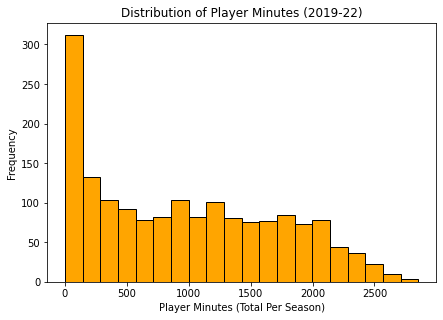

In [6]:
fig1 = plt.figure(figsize=(6,4))

axis1 = fig1.add_axes([0.1,0.1,0.9,0.9])

axis1.set_title('Distribution of Player Minutes (2019-22)')

axis1.set_xlabel('Player Minutes (Total Per Season)')

axis1.set_ylabel('Frequency')

axis1.hist(df['MIN'], bins=20, color='orange', ec='black')

plt.show()

To see that the player minutes is indicative of opportunities for production, let us just plot distributions of all of the other statistical categories.

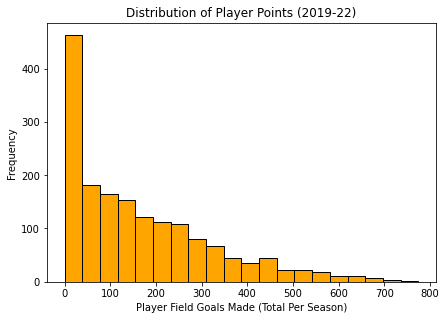

In [7]:
fig2 = plt.figure(figsize=(6,4))

axis2 = fig2.add_axes([0.1,0.1,0.9,0.9])

axis2.set_title('Distribution of Player Points (2019-22)')

axis2.set_xlabel('Player Field Goals Made (Total Per Season)')

axis2.set_ylabel('Frequency')

axis2.hist(df['PLAYER_FGM'], bins=20, color='orange', ec='black')

plt.show()

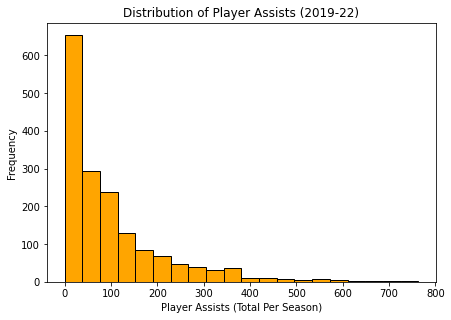

In [8]:
fig3 = plt.figure(figsize=(6,4))

axis3 = fig3.add_axes([0.1,0.1,0.9,0.9])

axis3.set_title('Distribution of Player Assists (2019-22)')

axis3.set_xlabel('Player Assists (Total Per Season)')

axis3.set_ylabel('Frequency')

axis3.hist(df['PLAYER_AST'], bins=20, color='orange', ec='black')

plt.show()

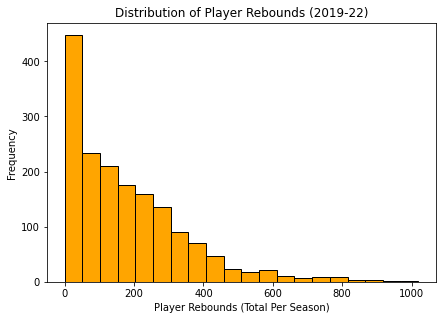

In [9]:
fig4 = plt.figure(figsize=(6,4))

axis4 = fig4.add_axes([0.1,0.1,0.9,0.9])

axis4.set_title('Distribution of Player Rebounds (2019-22)')

axis4.set_xlabel('Player Rebounds (Total Per Season)')

axis4.set_ylabel('Frequency')

axis4.hist(df['PLAYER_TREB'], bins=20, color='orange', ec='black')

plt.show()

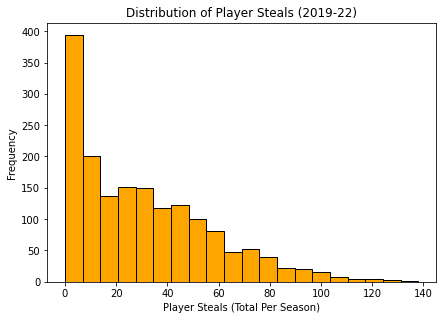

In [10]:
fig5 = plt.figure(figsize=(6,4))

axis5 = fig5.add_axes([0.1,0.1,0.9,0.9])

axis5.set_title('Distribution of Player Steals (2019-22)')

axis5.set_xlabel('Player Steals (Total Per Season)')

axis5.set_ylabel('Frequency')

axis5.hist(df['PLAYER_STL'], bins=20, color='orange', ec='black')

plt.show()

Thus, we see that every statistic is right-skewed and follows the pattern of the player minutes. However, we see that, sans outliers, the player minutes has the most *uniform* distribution. Therefore, we will filter by the player minutes.

For the filtering, we will only consider train on PERs of players that have played between 400 and 2300 total minutes in a season. This corresponds to roughly 1 standard deviation on the left side, and 2 standard deviations on the right side. Coincidentally, this is enough to make the distribution of player minutes somewhat uniform.

We are doing this because we don't want to consider the effects that players who contribute nothing to the team's statistical output have to the PER, as well as players who absolutely carry the teams on their backs.

In [11]:
df_train = df.loc[(df['MIN'] >= 200) & (df['MIN'] <= 2400)]

df_train

,PLAYER_NAME,TEAM_HIST,Season,MIN,PLAYER_FGM,PLAYER_FGA,PLAYER_FG3M,PLAYER_FTM,PLAYER_FTA,PLAYER_AST,...,TEAM_PF,TEAM_DREB%,TEAM_PACE,PLAYER_RAW_PER,PLAYER_PACE_CORRECTED_PER,Min * cPER,PLAYER_PER,PLAYER_TREB,PLAYER_FT_MISSED,PLAYER_FG_MISSED
0,Aaron Gordon,2020-21 DEN,2020-21,1383.780000,231,499,59,97,149,161,...,1374,0.751,99.3,0.318304,0.325100,449.866928,14.525479,284,52,268
1,Aaron Gordon,2021-22 DEN,2021-22,2375.418333,434,834,87,171,230,188,...,1639,0.752,99.9,0.336415,0.338694,804.539445,15.201557,439,59,400
2,Aaron Gordon,2019-20 ORL,2019-20,2017.143333,335,767,73,151,224,228,...,1336,0.749,100.9,0.329583,0.335397,676.544103,15.232287,475,73,432
4,Aaron Holiday,2019-20 IND,2019-20,1617.331667,233,563,87,74,87,225,...,1445,0.718,101.3,0.253952,0.257412,416.320241,11.690530,156,13,330
5,Aaron Holiday,2020-21 IND,2020-21,1176.086667,170,436,67,68,83,123,...,1453,0.701,104.0,0.216318,0.210951,248.097185,9.425317,89,15,266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1666,Zeke Nnaji,2020-21 DEN,2020-21,397.278333,50,104,24,12,15,10,...,1374,0.751,99.3,0.248150,0.253447,100.689154,11.324036,65,3,54
1667,Zeke Nnaji,2021-22 DEN,2021-22,697.608333,96,186,37,41,65,17,...,1639,0.752,99.9,0.294725,0.296721,206.995078,13.317699,147,24,90
1669,Ziaire Williams,2021-22 MEM,2021-22,1346.466667,191,424,76,43,55,65,...,1620,0.726,103.1,0.222252,0.216813,291.931368,9.731191,129,12,233
1670,Zion Williamson,2019-20 NOP,2019-20,668.141667,210,360,6,114,178,50,...,1524,0.729,106.3,0.538155,0.519828,347.318788,23.608341,150,64,150


### Pick Features

We will need to pick features that we will include in our model. Our choice is clearly stated at the beginning, we want to see if we can use ONLY player statistics to compute the PER within reasonable error. 

Therefore, we only pick player statistics that can be computed directly from a box score, **without** advanced statistics, team statistics, league-wide statistics.

In [12]:
df.columns

Index(['PLAYER_NAME', 'TEAM_HIST', 'Season', 'MIN', 'PLAYER_FGM', 'PLAYER_FGA',
       'PLAYER_FG3M', 'PLAYER_FTM', 'PLAYER_FTA', 'PLAYER_AST', 'PLAYER_TOV',
       'PLAYER_OREB', 'PLAYER_DREB', 'PLAYER_STL', 'PLAYER_BLK', 'PLAYER_PF',
       'TEAM_FGM', 'TEAM_AST', 'TEAM_FGA', 'TEAM_FTM', 'TEAM_FTA', 'TEAM_PTS',
       'TEAM_OREB', 'TEAM_TOV', 'TEAM_PF', 'TEAM_DREB%', 'TEAM_PACE',
       'PLAYER_RAW_PER', 'PLAYER_PACE_CORRECTED_PER', 'Min * cPER',
       'PLAYER_PER', 'PLAYER_TREB', 'PLAYER_FT_MISSED', 'PLAYER_FG_MISSED'],
      dtype='object')

In [13]:
li_features = ['PLAYER_FGM', 'PLAYER_FG_MISSED', 'PLAYER_FT_MISSED',
               'PLAYER_FG3M', 'PLAYER_FTM', 'PLAYER_AST', 'PLAYER_TOV',
               'PLAYER_OREB', 'PLAYER_DREB', 'PLAYER_STL', 'PLAYER_BLK', 'PLAYER_PF']

li_label = ['PLAYER_PER']

In [14]:
X = df_train[li_features]

y = df_train[li_label]

In [15]:
X.shape

(1258, 12)

In [16]:
y.shape

(1258, 1)

## Model Selection

Let us check if a linear model is appropriate here.

### 1. Linear Relationship

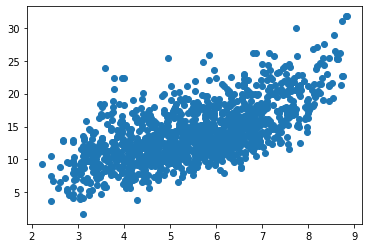

In [17]:
plt.scatter(np.power(X['PLAYER_FGM'], 1/3), y['PLAYER_PER'])


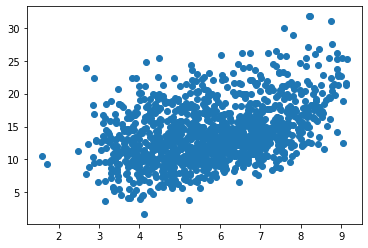

In [18]:
plt.scatter(np.power(X['PLAYER_FG_MISSED'], 1/3), y['PLAYER_PER'])

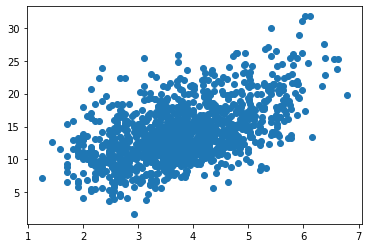

In [19]:
plt.scatter(np.power(X['PLAYER_TOV'], 1/3), y['PLAYER_PER'])


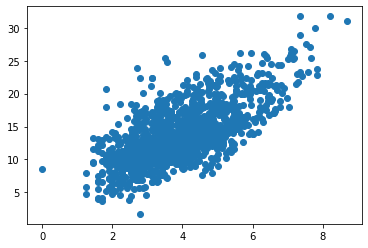

In [20]:
plt.scatter(np.power(X['PLAYER_FTM'], 1/3), y['PLAYER_PER'])


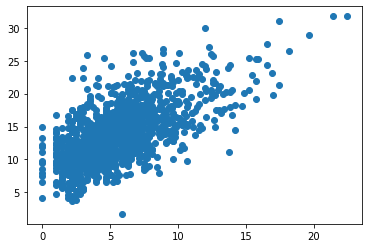

In [21]:
plt.scatter(np.power(X['PLAYER_FT_MISSED'], 1/1.75), y['PLAYER_PER'])


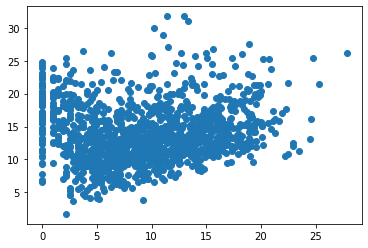

In [22]:
plt.scatter(np.power(X['PLAYER_FG3M'], 1/1.75), y['PLAYER_PER'])


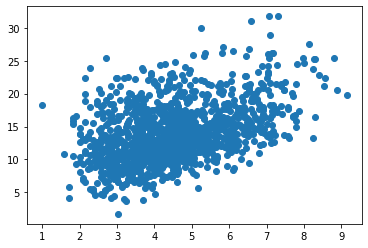

In [23]:
plt.scatter(np.power(X['PLAYER_AST'], 1/3), y['PLAYER_PER'])


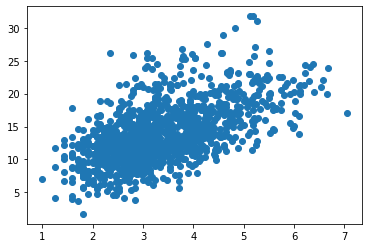

In [24]:
plt.scatter(np.power(X['PLAYER_OREB'], 1/3), y['PLAYER_PER'])


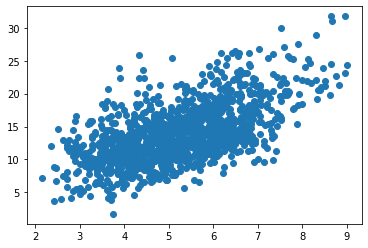

In [25]:
plt.scatter(np.power(X['PLAYER_DREB'], 1/3), y['PLAYER_PER'])


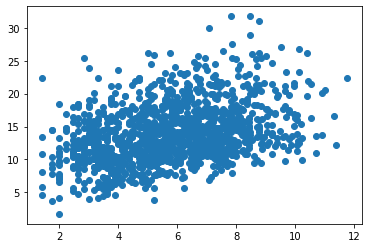

In [26]:
plt.scatter(np.power(X['PLAYER_STL'], 1/2), y['PLAYER_PER'])


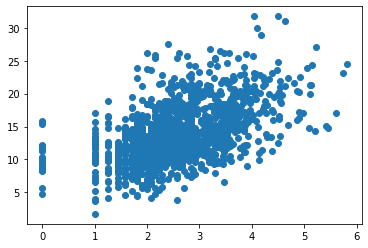

In [27]:
plt.scatter(np.power(X['PLAYER_BLK'], 1/3), y['PLAYER_PER'])


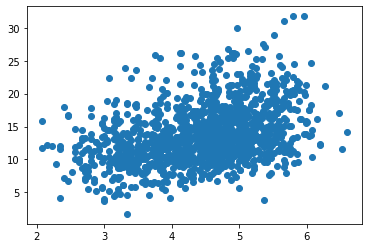

In [28]:
plt.scatter(np.power(X['PLAYER_PF'], 1/3), y['PLAYER_PER'])


After going through all 12 features we picked, we see that, with the necessary transformations, all of these are somewhat linear. In my personal opinion, it is linear enough to justify using a linear model and seeing what occurs.

### 2. Collinearity

We check if the variables are correlated strongly at all. If so, then we should probably exclude the features that are correlated strongly.

In [29]:
X.corr()

,PLAYER_FGM,PLAYER_FG_MISSED,PLAYER_FT_MISSED,PLAYER_FG3M,PLAYER_FTM,PLAYER_AST,PLAYER_TOV,PLAYER_OREB,PLAYER_DREB,PLAYER_STL,PLAYER_BLK,PLAYER_PF
PLAYER_FGM,1.000000,0.924721,0.678253,0.654696,0.854169,0.719869,0.873405,0.411271,0.747495,0.673913,0.389929,0.683532
PLAYER_FG_MISSED,0.924721,1.000000,0.505800,0.810638,0.782593,0.744055,0.844703,0.152763,0.585613,0.683059,0.191885,0.593107
PLAYER_FT_MISSED,0.678253,0.505800,1.000000,0.121692,0.748167,0.477030,0.687038,0.618379,0.717620,0.436697,0.526927,0.562082
PLAYER_FG3M,0.654696,0.810638,0.121692,1.000000,0.455568,0.503184,0.535810,-0.144487,0.315550,0.504720,-0.014660,0.407808
PLAYER_FTM,0.854169,0.782593,0.748167,0.455568,1.000000,0.673193,0.826839,0.343894,0.642743,0.540848,0.341082,0.544432
PLAYER_AST,0.719869,0.744055,0.477030,0.503184,0.673193,1.000000,0.863681,0.113159,0.485421,0.705449,0.083930,0.456893
PLAYER_TOV,0.873405,0.844703,0.687038,0.535810,0.826839,0.863681,1.000000,0.332575,0.682279,0.687989,0.295312,0.636372
PLAYER_OREB,0.411271,0.152763,0.618379,-0.144487,0.343894,0.113159,0.332575,1.000000,0.744151,0.279488,0.728146,0.597143
PLAYER_DREB,0.747495,0.585613,0.717620,0.315550,0.642743,0.485421,0.682279,0.744151,1.000000,0.560948,0.655498,0.739120
PLAYER_STL,0.673913,0.683059,0.436697,0.504720,0.540848,0.705449,0.687989,0.279488,0.560948,1.000000,0.307823,0.653930


We recognize that a few features are correlated rather strongly, but these are obvious correlations that we will ignore because we see these as necessary features to capture the full nuance of the player efficiency rating (all makes should be accompanied by misses to reflect a player's field goal percentage, an important aspect of efficiency).

### 3. Homoscedascity

We should do a more formal test for this, however, the above plots, with the necessary non-linear transformations, allow us to attain plots in which the residuals do not have a predictable "cone-like" shape. There may be a deeper pattern here in which heteroscedascity is attained, but we will assume it is not an issue for now.

Our conclusion is that a **linear model is likely appropriate for use here**.

## Building and Training a Model

We can use sklearn's models in order to train our models, however, we will opt to implement our own model and training loop.

### Apply non-linear transformations to data

As discussed above, our model will be of the form:

$$\hat{y} = w_{1}x_{FGM}^{1/3} + w_{2}x_{FG\;MISSED}^{1/3} + w_{3}x_{TOV}^{1/3} + w_{4}x_{FTM}^{1/3} + w_{5}x_{FT\;MISSED}^{1/1.75} + w_{6}x_{3PM}^{1/1.75} + w_{7}x_{AST}^{1/3} + w_{8}x_{OREB}^{1/3} + w_{9}x_{DREB}^{1/3} + w_{10}x_{STL}^{1/2} + w_{11}x_{BLK}^{1/3} + w_{12}x_{PF}^{1/3}$$

However, since we applied non-linear transformations to our data, we will **apply the non-linear transformations before we input the data into the model**. We will **incorporate the non-linear transformations into the preprocessing steps.**

In [30]:
X['PLAYER_FGM'] = np.power(X['PLAYER_FGM'], 1/3)

X['PLAYER_FG_MISSED'] = np.power(X['PLAYER_FG_MISSED'], 1/3)

X['PLAYER_TOV'] = np.power(X['PLAYER_TOV'], 1/3)

X['PLAYER_FTM'] = np.power(X['PLAYER_FTM'], 1/3)

X['PLAYER_FT_MISSED'] = np.power(X['PLAYER_FT_MISSED'], 1/1.75)

X['PLAYER_FG3M'] = np.power(X['PLAYER_FG3M'], 1/1.75)

X['PLAYER_AST'] = np.power(X['PLAYER_AST'], 1/3)

X['PLAYER_OREB'] = np.power(X['PLAYER_OREB'], 1/3)

X['PLAYER_DREB'] = np.power(X['PLAYER_DREB'], 1/3)

X['PLAYER_STL'] = np.power(X['PLAYER_STL'], 1/3)

X['PLAYER_BLK'] = np.power(X['PLAYER_BLK'], 1/3)

X['PLAYER_PF'] = np.power(X['PLAYER_PF'], 1/3)

C:\Users\Chang\AppData\Local\Temp\ipykernel_28940\703270180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['PLAYER_FGM'] = np.power(X['PLAYER_FGM'], 1/3)
C:\Users\Chang\AppData\Local\Temp\ipykernel_28940\703270180.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['PLAYER_FG_MISSED'] = np.power(X['PLAYER_FG_MISSED'], 1/3)
C:\Users\Chang\AppData\Local\Temp\ipykernel_28940\703270180.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

### Train Test Split Data

In [31]:
# use sklearn train test split to shuffle while splitting
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1006, 12), (252, 12), (1006, 1), (252, 1))

### Try Sci-kit Learn Linear Model

In [33]:
from sklearn.linear_model import LinearRegression

In [34]:
lin_model_sk = LinearRegression()

In [35]:
lin_model_sk.fit(X_train, y_train)

LinearRegression()

In [36]:
lin_model_sk.coef_.shape

(1, 12)

In [37]:
lin_model_sk.coef_

array([[ 5.05792864, -4.33649078, -0.10805209,  0.11507979,  1.95809508,
         0.79811424, -0.56956564,  0.64445409,  0.16944118, -0.350747  ,
         0.98364297, -3.01366394]])

In [38]:
lin_model_sk.intercept_

array([10.46917932])

In [39]:
y_pred = lin_model_sk.predict(X_test)

In [40]:
def rmse(y, y_hat):
    return np.sqrt(np.mean((y - y_hat)**2))

In [41]:
rmse(np.array(y_test), y_pred)

1.8226936816939867

### Build Custom Linear Model on TensorFlow

The Sci-Kit Learn implementation of the linear regression model has a direct closed-form solution for the minimum. To demonstrate that we can implement this same model on our own with little trouble, let us use tensorflow to show that we can attain the same results as the sci-kit learn implementation, then we can find a way to improve our model tremendously after the fact.

In [42]:
import tensorflow as tf

In [43]:
X.shape

(1258, 12)

#### Linear Regression Model v1

We expect this to have the same result as the closed-form procedure for the Ordinary Least Squares Problem.

In [44]:
# CREATE A CUSTOM LINEAR REGRESSION MODEL IN TENSORFLOW

class LinearModel(tf.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        # don't initialize weights until we get an input
        self.w = None
        self.b = None
        
    def __call__(self, x):
        # initialize weights to match shape of input if the parameters are None
        if self.w is None and self.b is None:
            self.w = tf.Variable(tf.random.normal(shape=(x.shape[1], 1)), trainable=True, name='W', dtype=tf.float32)
#             self.b = tf.Variable(tf.random.normal(shape=(x.shape[0], 1)), trainable=True, name='b', dtype=tf.float32)
            self.b = tf.Variable(tf.random.normal(shape=()), trainable=True, name='b', dtype=tf.float32)
        else:
            pass
        
        # our model will be x.W^T + b
        
        # compute dot product of weights and input and add bias
        return tf.matmul(x, self.w) + tf.multiply(self.b, tf.ones(shape=(x.shape[0], 1)))

**Notice:** The trainable parameters are initialized to being none initially. We want the model to infer the parameter dimensions based on the input. This should update everytime we feed it forward.

In [45]:
lin_model = LinearModel()

# model.b, model.w

We must convert all of our model inputs to tensors.

In [46]:
X_train_tf, X_test_tf = tf.constant(np.array(X_train), dtype=tf.float32), tf.constant(np.array(X_test), dtype=tf.float32)

y_train_tf, y_test_tf = tf.constant(np.array(y_train), dtype=tf.float32), tf.constant(np.array(y_test), dtype=tf.float32)

X_train_tf.shape, X_test_tf.shape, y_train_tf.shape, y_test_tf.shape

(TensorShape([1006, 12]),
 TensorShape([252, 12]),
 TensorShape([1006, 1]),
 TensorShape([252, 1]))

Test the feedforward to make sure that our variables are initializing in the feedforward!

In [47]:
# model(X_train_tf)

Now that we fed it forward in our model once, we should have some non-null parameters.

In [48]:
# model.b, model.w

In [49]:
# USE A MEAN SQUARE ERROR LOSS

@tf.function
def mse_loss(y, y_hat):
    return tf.reduce_mean(tf.pow(y - y_hat, 2))

In [50]:
import timeit as t

In [51]:
# method to fit the model by optimizing the loss
def fit(x, y, epochs, model, loss_fn, optimizer):
    # time it so we can benchmark performance
    total_train_time = 0
    epoch_group_train_time = 0
    
    for epoch in range(epochs):
        start_epoch = t.default_timer()
        with tf.GradientTape(persistent=True) as tp:
            # COMPUTATIONS THAT ARE INVOLVED IN THE OPTIMIZATION ARE IN SCOPE OF AUTOGRAD
            # initialize y_hat
            y_hat = model(x)
            # compute loss
            loss = loss_fn(y, y_hat)
        
        # compute gradients tracked in autograd
        dloss = tp.gradient(loss, model.variables)
        
        # optimize
        optimizer.apply_gradients(zip(dloss, model.variables))
        
        end_epoch = t.default_timer()
        
        total_train_time += (end_epoch - start_epoch)
        epoch_group_train_time += (end_epoch - start_epoch)
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch + 1} | Loss {loss_fn(y, y_hat).numpy():.4f} | 100 Epochs Runtime {epoch_group_train_time} sec.')
            
            # get time of this batch of train times and reset it after
            epoch_group_train_time = 0
        
    print(f'Total Training Time {total_train_time} sec.')

In [52]:
learning_rate = 0.001

fit(X_train_tf, y_train_tf, 20000, lin_model, mse_loss, tf.keras.optimizers.Adam(learning_rate))

Epoch 100 | Loss 32.2841 | 100 Epochs Runtime 0.7855719000000185 sec.
Epoch 200 | Loss 18.7689 | 100 Epochs Runtime 0.662196699999992 sec.
Epoch 300 | Loss 17.4986 | 100 Epochs Runtime 0.6417247000000081 sec.
Epoch 400 | Loss 17.2975 | 100 Epochs Runtime 0.6715275999999868 sec.
Epoch 500 | Loss 17.1211 | 100 Epochs Runtime 0.6619473000000262 sec.
Epoch 600 | Loss 16.9391 | 100 Epochs Runtime 0.6698956000000003 sec.
Epoch 700 | Loss 16.7550 | 100 Epochs Runtime 0.657983300000005 sec.
Epoch 800 | Loss 16.5714 | 100 Epochs Runtime 0.6753171000000187 sec.
Epoch 900 | Loss 16.3902 | 100 Epochs Runtime 0.5888528999999956 sec.
Epoch 1000 | Loss 16.2123 | 100 Epochs Runtime 0.6455084000000113 sec.
Epoch 1100 | Loss 16.0381 | 100 Epochs Runtime 0.6105654999999857 sec.
Epoch 1200 | Loss 15.8676 | 100 Epochs Runtime 0.6627978999999797 sec.
Epoch 1300 | Loss 15.7007 | 100 Epochs Runtime 0.6372981000000202 sec.
Epoch 1400 | Loss 15.5368 | 100 Epochs Runtime 0.6437486999999926 sec.
Epoch 1500 | Loss

Epoch 11800 | Loss 4.2719 | 100 Epochs Runtime 0.5902948000000521 sec.
Epoch 11900 | Loss 4.2500 | 100 Epochs Runtime 0.5856446000000375 sec.
Epoch 12000 | Loss 4.2291 | 100 Epochs Runtime 0.5748772999999971 sec.
Epoch 12100 | Loss 4.2091 | 100 Epochs Runtime 0.6804970999999398 sec.
Epoch 12200 | Loss 4.1902 | 100 Epochs Runtime 0.6414979000000898 sec.
Epoch 12300 | Loss 4.1723 | 100 Epochs Runtime 0.6424332999999933 sec.
Epoch 12400 | Loss 4.1552 | 100 Epochs Runtime 0.6135184000000606 sec.
Epoch 12500 | Loss 4.1390 | 100 Epochs Runtime 0.6271401000000054 sec.
Epoch 12600 | Loss 4.1237 | 100 Epochs Runtime 0.6350831999999969 sec.
Epoch 12700 | Loss 4.1092 | 100 Epochs Runtime 0.6317263999999909 sec.
Epoch 12800 | Loss 4.0955 | 100 Epochs Runtime 0.653507699999949 sec.
Epoch 12900 | Loss 4.0825 | 100 Epochs Runtime 0.3942489999999452 sec.
Epoch 13000 | Loss 4.0703 | 100 Epochs Runtime 0.6161814999999109 sec.
Epoch 13100 | Loss 4.0587 | 100 Epochs Runtime 0.6335942000000614 sec.
Epoch 1

**Note: I recommend using Adam optimizer over Stochastic Gradient Descent because the SGD is very slow and takes a long time to converge. The training loss is never indicative of a model's general performance, but the training losses for the Adam optimizer indicate that it is the better thing to use.**

#### Evaluate Custom Model

We got the training loss decently low, let us see if this fares better than the sklearn model!

In [53]:
# RUN FEEDFORWARD AND PREDICT A PER

test_loss = tf.sqrt(mse_loss(y_test_tf, lin_model(X_test_tf))).numpy()

print(f'The root mean square error of our model on our test set is {test_loss:.5f} PER scores.')

The root mean square error of our model on our test set is 1.82270 PER scores.


#### Linear Regression Model v2

We will try something different here. In our above implementation, we had a model of the form:

$$y_{hat} = Wx + b$$

Where $b$ is of the form:

$$\dot{b} \cdot \mathbf{1}$$

And $\dot{b}$ is a fixed constant and $\mathbf{1}$ is an appropriate vector with only 1's as entries.

However, we can actually make this model smarter by replacing $b$ with a different $b$ in which every entry is different. The only thing is that there is no way to make the dimensions match (because in our implementation of OLS, we fixed the size of the bias to be a vector of ones [i.e. the $\mathbf{1}$] that would match in dimension of the desired output). We can circumvent this by combining entries of our tensor. We will demonstrate below.

In [54]:
# CREATE A CUSTOM LINEAR REGRESSION MODEL IN TENSORFLOW, IMPLEMENT OUR PROPOSED IDEA

class LinearModelv2(tf.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        # don't initialize weights until we get an input
        self.w = None
        self.b = None
        
    def __call__(self, x):
        # initialize weights to match shape of input if the parameters are None
        if self.w is None and self.b is None:
            self.w = tf.Variable(tf.random.normal(shape=(x.shape[1], 1)), trainable=True, name='W', dtype=tf.float32)
            self.b = tf.Variable(tf.random.normal(shape=(x.shape[0], 1)), trainable=True, name='b', dtype=tf.float32)
        else:
            pass
        
        # our model will be x.W^T + b
        
        # compute dot product of weights and input and add bias
        return tf.matmul(x, self.w) + self.b

In [55]:
lin_modelv2 = LinearModelv2()

In [56]:
learning_rate = 0.001

fit(X_train_tf, y_train_tf, 10000, lin_modelv2, mse_loss, tf.keras.optimizers.Adam(learning_rate))

Epoch 100 | Loss 81.0690 | 100 Epochs Runtime 0.6874990999999397 sec.
Epoch 200 | Loss 33.6354 | 100 Epochs Runtime 0.6779180999999426 sec.
Epoch 300 | Loss 19.6624 | 100 Epochs Runtime 0.650222399999933 sec.
Epoch 400 | Loss 16.2146 | 100 Epochs Runtime 0.6273275999999441 sec.
Epoch 500 | Loss 14.9389 | 100 Epochs Runtime 0.6336412999999084 sec.
Epoch 600 | Loss 13.9757 | 100 Epochs Runtime 0.6343061999998554 sec.
Epoch 700 | Loss 13.0738 | 100 Epochs Runtime 0.6244901999998547 sec.
Epoch 800 | Loss 12.2192 | 100 Epochs Runtime 0.6147053999999628 sec.
Epoch 900 | Loss 11.4173 | 100 Epochs Runtime 0.6175511999998946 sec.
Epoch 1000 | Loss 10.6724 | 100 Epochs Runtime 0.6263133999999013 sec.
Epoch 1100 | Loss 9.9856 | 100 Epochs Runtime 0.6146960999999465 sec.
Epoch 1200 | Loss 9.3563 | 100 Epochs Runtime 0.615713299999868 sec.
Epoch 1300 | Loss 8.7819 | 100 Epochs Runtime 0.6219093999998222 sec.
Epoch 1400 | Loss 8.2588 | 100 Epochs Runtime 0.6339883000001407 sec.
Epoch 1500 | Loss 7.7

In [57]:
const = lin_modelv2.b.shape[0]//y_test_tf.shape[0]

In [58]:
# tf.concat([tf.reshape(tf.reduce_mean(lin_modelv2.b[0:3]), shape=(1, 1)), tf.reshape(tf.reduce_mean(lin_modelv2.b[3:6]), shape=(1, 1))], 0)

In [59]:
li_bias = []
for i in range(0, y_test_tf.shape[0]):
    if i < y_test_tf.shape[0] - 1 - const:
        li_bias.append(tf.reshape(tf.reduce_mean(lin_modelv2.b[i:i+const]), shape=(1,1)))
    else:
        li_bias.append(tf.reshape(tf.reduce_mean(lin_modelv2.b[i:-1]), shape=(1,1)))

In [60]:
new_b = tf.concat(li_bias, axis=0)

new_b.shape

TensorShape([252, 1])

In [61]:
X_test_tf.shape

TensorShape([252, 12])

In [62]:
y_predv2 = tf.matmul(X_test_tf, lin_modelv2.w) + new_b

In [63]:
y_test_tf.shape

TensorShape([252, 1])

In [64]:
tf.sqrt(mse_loss(y_test_tf, y_predv2)).numpy()

3.1444368

The result for our new linear model method is not nearly as good as our initial ordinary least squares method, despite the training loss being extremely low. We will settle for the ordinary least squares model.

## Compare Results from Both TensorFlow and Scikit Implementations

In [65]:
# TENSORFLOW WEIGHTS

lin_model.w, lin_model.b

(<tf.Variable 'W:0' shape=(12, 1) dtype=float32, numpy=
 array([[ 5.0578337 ],
        [-4.336325  ],
        [-0.10807285],
        [ 0.11505914],
        [ 1.9581013 ],
        [ 0.7980993 ],
        [-0.5695689 ],
        [ 0.6444621 ],
        [ 0.16945395],
        [-0.3507544 ],
        [ 0.9836341 ],
        [-3.0135841 ]], dtype=float32)>,
 <tf.Variable 'b:0' shape=() dtype=float32, numpy=10.468635>)

In [66]:
# SCI-KIT LEARN WEIGHTS

lin_model_sk.coef_, lin_model_sk.intercept_

(array([[ 5.05792864, -4.33649078, -0.10805209,  0.11507979,  1.95809508,
          0.79811424, -0.56956564,  0.64445409,  0.16944118, -0.350747  ,
          0.98364297, -3.01366394]]),
 array([10.46917932]))

As expected, the coefficients are almost exactly the same as well.

## Make Some Predictions

Let us make some predictions about player PERs now.

We need to draft an evaluation pipeline.

In [78]:
li_features = ['PLAYER_FGM', 'PLAYER_FG_MISSED', 'PLAYER_FT_MISSED',
               'PLAYER_FG3M', 'PLAYER_FTM', 'PLAYER_AST', 'PLAYER_TOV',
               'PLAYER_OREB', 'PLAYER_DREB', 'PLAYER_STL', 'PLAYER_BLK', 'PLAYER_PF']

In [85]:
def predict(FGM, FG_MISSED, FT_MISSED, FG3M, FTM, AST, TOV, OREB, DREB, STL, BLK, PF, model):
    # perform nonlinear transformation of inputs
    
    li = [np.power(FGM, 1/3), np.power(FG_MISSED, 1/3), np.power(FT_MISSED, 1/1.75), np.power(FG3M, 1/1.75), np.power(FTM, 1/3),
        np.power(AST, 1/3), np.power(TOV, 1/3), np.power(OREB, 1/3), np.power(DREB, 1/3), np.power(STL, 1/3), np.power(BLK, 1/3),
        np.power(PF, 1/3)]

    x = np.array(li)
    
    # predict PER
    return np.dot(np.reshape(model.w.numpy(), -1), x) + model.b.numpy()

### Nikola Jokic

This is a good test because Jokic is the leader in PER in the 2021-22 season.

In [98]:
print(df.loc[(df['PLAYER_NAME'] == 'Nikola Jokic') & (df['Season'] == '2021-22')].index)

player = df[li_features].iloc[1245]

player_true_per = df[li_label].iloc[1245]

player

Int64Index([1245], dtype='int64')


PLAYER_FGM          764
PLAYER_FG_MISSED    547
PLAYER_FT_MISSED     89
PLAYER_FG3M          97
PLAYER_FTM          379
PLAYER_AST          584
PLAYER_TOV          281
PLAYER_OREB         206
PLAYER_DREB         813
PLAYER_STL          109
PLAYER_BLK           63
PLAYER_PF           191
Name: 1245, dtype: int64

In [99]:
nikola_21_22_per = predict(player['PLAYER_FGM'], player['PLAYER_FG_MISSED'], player['PLAYER_FT_MISSED'],
                          player['PLAYER_FG3M'], player['PLAYER_FTM'], player['PLAYER_AST'],
                          player['PLAYER_TOV'], player['PLAYER_OREB'], player['PLAYER_DREB'],
                          player['PLAYER_STL'], player['PLAYER_BLK'], player['PLAYER_PF'], lin_model)

print(f'Nikola Jokic\'s predicted PER is {nikola_21_22_per}.')

print(f'Nikola Jokic\'s actual PER is {player_true_per}.')

Nikola Jokic's predicted PER is 28.79060348818826.
Nikola Jokic's actual PER is PLAYER_PER    32.506083
Name: 1245, dtype: float64.


### Giannis Antetokounmpo

He is second on the list, so let's see where he stands.

In [104]:
ind = df.loc[(df['PLAYER_NAME'] == 'Giannis Antetokounmpo') & (df['Season'] == '2021-22')].index[0]

player = df[li_features].iloc[ind]

player_true_per = df[li_label].iloc[ind]

player

PLAYER_FGM          689
PLAYER_FG_MISSED    556
PLAYER_FT_MISSED    213
PLAYER_FG3M          71
PLAYER_FTM          553
PLAYER_AST          388
PLAYER_TOV          219
PLAYER_OREB         134
PLAYER_DREB         644
PLAYER_STL           72
PLAYER_BLK           91
PLAYER_PF           212
Name: 570, dtype: int64

In [106]:
giannis_21_22_per = predict(player['PLAYER_FGM'], player['PLAYER_FG_MISSED'], player['PLAYER_FT_MISSED'],
                          player['PLAYER_FG3M'], player['PLAYER_FTM'], player['PLAYER_AST'],
                          player['PLAYER_TOV'], player['PLAYER_OREB'], player['PLAYER_DREB'],
                          player['PLAYER_STL'], player['PLAYER_BLK'], player['PLAYER_PF'], lin_model)

print(f'Giannis Antetokounmpo\'s predicted PER is {giannis_21_22_per}.')

print(f'Giannis Antetokounmpo\'s actual PER is {player_true_per}.')

Giannis Antetokounmpo's predicted PER is 26.702318668684832.
Giannis Antetokounmpo's actual PER is PLAYER_PER    31.756358
Name: 570, dtype: float64.


### Joel Embiid

He is third on our list.

In [107]:
ind = df.loc[(df['PLAYER_NAME'] == 'Joel Embiid') & (df['Season'] == '2021-22')].index[0]

player = df[li_features].iloc[ind]

player_true_per = df[li_label].iloc[ind]

player

PLAYER_FGM          666
PLAYER_FG_MISSED    668
PLAYER_FT_MISSED    149
PLAYER_FG3M          93
PLAYER_FTM          654
PLAYER_AST          284
PLAYER_TOV          214
PLAYER_OREB         146
PLAYER_DREB         650
PLAYER_STL           77
PLAYER_BLK           99
PLAYER_PF           181
Name: 807, dtype: int64

In [108]:
embiid_21_22_per = predict(player['PLAYER_FGM'], player['PLAYER_FG_MISSED'], player['PLAYER_FT_MISSED'],
                          player['PLAYER_FG3M'], player['PLAYER_FTM'], player['PLAYER_AST'],
                          player['PLAYER_TOV'], player['PLAYER_OREB'], player['PLAYER_DREB'],
                          player['PLAYER_STL'], player['PLAYER_BLK'], player['PLAYER_PF'], lin_model)

print(f'Joel Embiid\'s predicted PER is {embiid_21_22_per}.')

print(f'Joel Embiid\'s actual PER is {player_true_per}.')

Joel Embiid's predicted PER is 26.087899691215835.
Joel Embiid's actual PER is PLAYER_PER    30.986037
Name: 807, dtype: float64.


### LeBron James

He is fourth on our list.

In [109]:
ind = df.loc[(df['PLAYER_NAME'] == 'LeBron James') & (df['Season'] == '2021-22')].index[0]

player = df[li_features].iloc[ind]

player_true_per = df[li_label].iloc[ind]

player

PLAYER_FGM          640
PLAYER_FG_MISSED    581
PLAYER_FT_MISSED     82
PLAYER_FG3M         161
PLAYER_FTM          254
PLAYER_AST          349
PLAYER_TOV          196
PLAYER_OREB          63
PLAYER_DREB         396
PLAYER_STL           73
PLAYER_BLK           59
PLAYER_PF           121
Name: 1036, dtype: int64

In [111]:
bron_21_22_per = predict(player['PLAYER_FGM'], player['PLAYER_FG_MISSED'], player['PLAYER_FT_MISSED'],
                          player['PLAYER_FG3M'], player['PLAYER_FTM'], player['PLAYER_AST'],
                          player['PLAYER_TOV'], player['PLAYER_OREB'], player['PLAYER_DREB'],
                          player['PLAYER_STL'], player['PLAYER_BLK'], player['PLAYER_PF'], lin_model)

print(f'LeBron James\'s predicted PER is {bron_21_22_per}.')

print(f'LeBron James\'s actual PER is {player_true_per}.')

LeBron James's predicted PER is 24.60795718163623.
LeBron James's actual PER is PLAYER_PER    26.005317
Name: 1036, dtype: float64.


### Kevin Durant

Durant is 5th on our PER list, let us check him last.

In [112]:
ind = df.loc[(df['PLAYER_NAME'] == 'Kevin Durant') & (df['Season'] == '2021-22')].index[0]

player = df[li_features].iloc[ind]

player_true_per = df[li_label].iloc[ind]

player

PLAYER_FGM          578
PLAYER_FG_MISSED    537
PLAYER_FT_MISSED     37
PLAYER_FG3M         115
PLAYER_FTM          372
PLAYER_AST          351
PLAYER_TOV          191
PLAYER_OREB          29
PLAYER_DREB         378
PLAYER_STL           48
PLAYER_BLK           52
PLAYER_PF           113
Name: 953, dtype: int64

In [113]:
KD_21_22_per = predict(player['PLAYER_FGM'], player['PLAYER_FG_MISSED'], player['PLAYER_FT_MISSED'],
                          player['PLAYER_FG3M'], player['PLAYER_FTM'], player['PLAYER_AST'],
                          player['PLAYER_TOV'], player['PLAYER_OREB'], player['PLAYER_DREB'],
                          player['PLAYER_STL'], player['PLAYER_BLK'], player['PLAYER_PF'], lin_model)

print(f'Kevin Durant\'s predicted PER is {KD_21_22_per}.')

print(f'Kevin Durant\'s actual PER is {player_true_per}.')

Kevin Durant's predicted PER is 25.69947460878935.
Kevin Durant's actual PER is PLAYER_PER    25.466527
Name: 953, dtype: float64.


We see the first instance of our model failing to capture the correct relationship here. Kevin Durant's PER, according to our model, is actually higher than LeBron's. Of course our data says this is not true, but it is interesting nonetheless. This tells us that this model we built is pretty good at differentiating the order of the PER's of outstanding, MVP-candidate players, but when we go to lower tiers, the order is not preserved as well. Another thing to note is that this model seems to underscore the players with high PER's, and that it overscores players with lower PER's. Whether this is true or not is yet to be seen, but it is a notable observation from just even looking at the top 5 players.